In [28]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.preprocessing import StandardScaler

In [29]:
ds = pd.read_csv('movies.csv', encoding='latin1', sep=",")
ds.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [30]:
ds.info(verbose=True, null_counts=True)
(ds==0).sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   budget    6820 non-null   float64
 1   company   6820 non-null   object 
 2   country   6820 non-null   object 
 3   director  6820 non-null   object 
 4   genre     6820 non-null   object 
 5   gross     6820 non-null   float64
 6   name      6820 non-null   object 
 7   rating    6820 non-null   object 
 8   released  6820 non-null   object 
 9   runtime   6820 non-null   int64  
 10  score     6820 non-null   float64
 11  star      6820 non-null   object 
 12  votes     6820 non-null   int64  
 13  writer    6820 non-null   object 
 14  year      6820 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


budget      2182
company        0
country        0
director       0
genre          0
gross          0
name           0
rating         0
released       0
runtime        0
score          0
star           0
votes          0
writer         0
year           0
dtype: int64

In [31]:
ds.describe(include="all")
ds.dtypes

budget      float64
company      object
country      object
director     object
genre        object
gross       float64
name         object
rating       object
released     object
runtime       int64
score       float64
star         object
votes         int64
writer       object
year          int64
dtype: object

<AxesSubplot:>

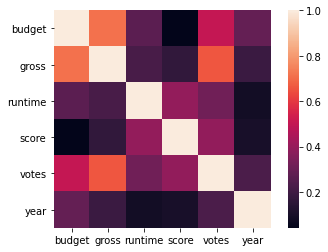

In [32]:
ds_corr = ds[["budget", "gross", "runtime", "score", "votes", "year"]]
cor = ds_corr.corr() 
sns.heatmap(cor, square = True) 

In [33]:
ds["budget"].replace(0, np.nan, inplace=True)
print(ds["budget"])
ds["budget"].fillna(ds["budget"].sum() / ds["gross"].sum() * ds["gross"], inplace=True)

print(ds["budget"])

ds =ds[~ds["rating"].isin(["NOT RATED", "UNRATED", "Not specified"])]

ds["gross_to_budget_ratio"] = ds["gross"] / ds["budget"] #feature engineering


# ds = ds[["budget", "country", "genre", "gross", "rating", "runtime", "score", "year", "gross_to_budget_ratio"]] #keeping only the most relevant features
ds = ds[["budget", "gross", "runtime", "score", "year", "gross_to_budget_ratio"]] 

# ds = pd.concat([ds, pd.get_dummies(ds["genre"])], axis=1) #genre dummy coding
# ds = pd.concat([ds, pd.get_dummies(ds["rating"])], axis=1) #rating dummy coding

ds.dtypes

0        8000000.0
1        6000000.0
2       15000000.0
3       18500000.0
4        9000000.0
           ...    
6815           NaN
6816           NaN
6817     3500000.0
6818           NaN
6819           NaN
Name: budget, Length: 6820, dtype: float64
0       8.000000e+06
1       6.000000e+06
2       1.500000e+07
3       1.850000e+07
4       9.000000e+06
            ...     
6815    3.485975e+06
6816    2.081680e+04
6817    3.500000e+06
6818    1.906519e+04
6819    2.770656e+04
Name: budget, Length: 6820, dtype: float64


budget                   float64
gross                    float64
runtime                    int64
score                    float64
year                       int64
gross_to_budget_ratio    float64
dtype: object

In [34]:
ds1 = ds[["budget", "gross", "runtime", "score", "year"]]
ss = StandardScaler()
ss.fit_transform(ds)

array([[-0.523655  ,  0.29175287, -0.98842565,  1.75132513, -1.66830247,
         0.03372907],
       [-0.57782106,  0.59373235, -0.19246768,  1.45157931, -1.66830247,
         0.08850917],
       [-0.33407378,  2.44909859,  0.20551131,  0.55234183, -1.66830247,
         0.09166952],
       ...,
       [-0.64552864, -0.52900968, -1.72752948,  0.15268073,  1.68712695,
        -0.02428128],
       [-0.7398029 , -0.59243787, -1.72752948, -0.1470651 ,  1.68712695,
        -0.02126058],
       [-0.73956887, -0.59223864,  0.77405271,  0.35251128,  1.68712695,
        -0.02126058]])

In [35]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(ds, 2)
kmeans = pd.DataFrame(clust_labels)
ds.insert((ds.shape[1]),'kmeans',kmeans)

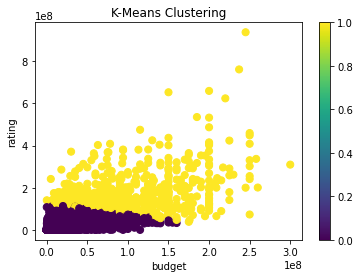

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(ds['budget'],ds['gross'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('budget')
ax.set_ylabel('rating')
plt.colorbar(scatter)